<a href="https://colab.research.google.com/github/kelvinmadeleke/amazon-product-review-ml-with-sentiment-analysis/blob/main/amazon_product_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import re
from textblob import TextBlob
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
cf.go_offline();
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('/content/amazon_reviews.csv')

In [5]:
df.head(1)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [7]:
null_values = df.isnull().sum()
null_values

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [8]:
df = df.sort_values('wilson_lower_bound',ascending=False)
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5.0,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,2013-01-05,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5.0,I have tested dozens of SDHC and micro-SDHC ca...,2012-09-26,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1.0,NOTE: please read the last update (scroll to ...,2013-05-08,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1.0,"If your card gets hot enough to be painful, it...",2012-02-09,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5.0,Sandisk announcement of the first 128GB micro ...,2014-07-03,158,45,4,49,41,0.918367,0.808109


 *missing_values_analysis(df)*
This function checks for missing values in a dataframe and provides a summary. It identifies columns with missing data, counts the missing values, and calculates the percentage of missing data for each column. The results are returned as a DataFrame with two columns: total missing values and the percentage of missing values.

 *check_df(df, head=5, tail=5)*
This function provides a basic overview of the dataframe. It prints the number of rows and columns, and optionally, it can display the first few (head) and last few (tail) rows of the dataframe to help inspect the data quickly. **bold text**



In [9]:
def missing_values_analysis(df):
  na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
  n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
  ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
  missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
  missing_df = pd.DataFrame(missing_df)
  return missing_df

def check_dataframe(df, head=5, tail=5):
    print("SHAPE".center(82,'~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print("TYPES".center(82,'~'))
    print(df.dtypes)
    print("".center(82,'~'))
    print(missing_values_analysis(df))
    print("DUPLICATED VALUES".center(83,'~'))
    print(df.duplicated().sum())
    print("QUANTILES".center(82,'~'))
    numeric_df = df.select_dtypes(include=np.number)
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Total Missing Values  Ratio
reviewerName                     1   0.02
reviewText                       1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99    

1. Check the Number of Unique Values in Each Column
2. List the Unique Values for Each Column
3. Display Unique Values with Their Counts

In [10]:
unique_counts = df.nunique()
print(unique_counts.sort_values(ascending=True))

#for column in df.columns:
    #print(f"Unique values in '{column}':")
    #print(df[column].unique())
    #print("-" * 50)

#for column in df.columns:
    #print(f"Value counts for '{column}':")
    #print(df[column].value_counts())
    #print("-" * 50)


overall                    5
helpful_no                17
helpful_yes               23
total_vote                26
score_pos_neg_diff        27
score_average_rating      28
wilson_lower_bound        40
reviewTime               690
day_diff                 690
reviewerName            4594
reviewText              4912
dtype: int64


cleaning our data the review part

In [12]:
column_count = df['reviewText'].count()
print(f"Number of values in 'reviewText': {column_count}")

Number of values in 'reviewText': 4914


In [13]:
total_rows = len(df['reviewText'])
print(f"Total number of rows in 'reviewText': {total_rows}")

Total number of rows in 'reviewText': 4915


In [14]:
#  This specifies that rows should be dropped if either reviewer_name or review_text is missing.
df = df.dropna(subset=['reviewerName', 'reviewText'])
print(f"Rows after dropping missing values: {df.shape[0]}")

Rows after dropping missing values: 4913


In [15]:
!pip install nltk
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the stopwords
stop_words = set(stopwords.words('english'))


def clean_text(text):
    # 1. Remove unwanted characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 2. Convert text to lowercase
    text = text.lower()

    # 3. Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # 4. Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [17]:

df['cleaned_reviewText'] = df['reviewText'].apply(clean_text)


print(df[['reviewText', 'cleaned_reviewText']].head())

                                             reviewText  \
2031  [[ UPDATE - 6/19/2014 ]]So my lovely wife boug...   
3449  I have tested dozens of SDHC and micro-SDHC ca...   
4212  NOTE:  please read the last update (scroll to ...   
317   If your card gets hot enough to be painful, it...   
4672  Sandisk announcement of the first 128GB micro ...   

                                     cleaned_reviewText  
2031  update lovely wife bought samsung galaxy tab f...  
3449  tested dozen sdhc microsdhc card one disturbin...  
4212  note please read last update scroll bottom im ...  
317   card get hot enough painful defective need con...  
4672  sandisk announcement first gb micro sd took in...  


### data sentiment **analysis**

In [18]:
def assign_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['overall'].apply(assign_sentiment)

In [20]:
sentiment_counts = df['sentiment'].value_counts()
print(f"Sentiment Distribution:\n{sentiment_counts}")

Sentiment Distribution:
sentiment
positive    4447
negative     324
neutral      142
Name: count, dtype: int64


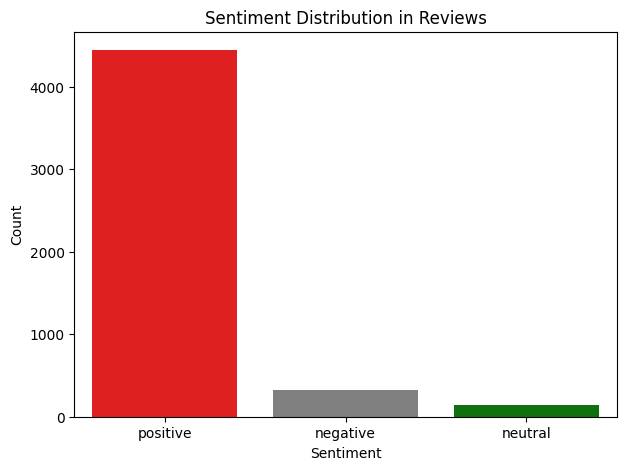

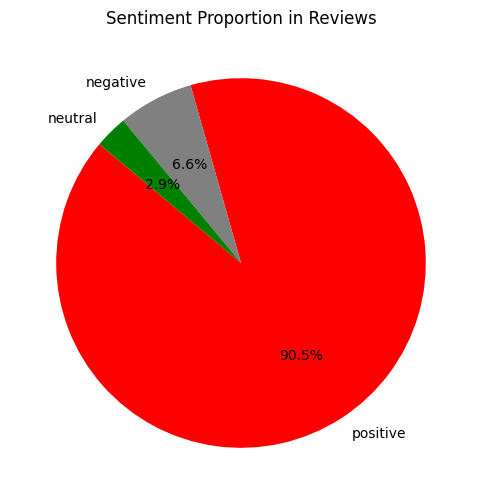

In [21]:
# Bar Chart
plt.figure(figsize=(7,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'gray', 'green'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Reviews")
plt.show()

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'gray', 'green'], startangle=140)
plt.title("Sentiment Proportion in Reviews")
plt.show()

FEATURE ENGINEERING *TEXT* *VECTORIZATION*

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_reviewText'])
y = df['sentiment']


In [28]:
print(X.shape)

print(vectorizer.get_feature_names_out()[:20])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

(4913, 5000)
['ability' 'able' 'absolute' 'absolutely' 'abuse' 'accept' 'acceptable'
 'accepted' 'accepting' 'accepts' 'access' 'accessed' 'accessible'
 'accessing' 'accessory' 'accident' 'accidentally' 'accidently'
 'accommodate' 'accomplish']
    ability     able  absolute  absolutely  abuse  accept  acceptable  \
0  0.034403  0.00000       0.0    0.031193    0.0     0.0         0.0   
1  0.000000  0.00000       0.0    0.000000    0.0     0.0         0.0   
2  0.000000  0.00000       0.0    0.023140    0.0     0.0         0.0   
3  0.000000  0.00000       0.0    0.000000    0.0     0.0         0.0   
4  0.000000  0.04929       0.0    0.000000    0.0     0.0         0.0   

   accepted  accepting  accepts  ...  zip  zippy   zl  zone  zoning  zoom  \
0       0.0        0.0      0.0  ...  0.0    0.0  0.0   0.0     0.0   0.0   
1       0.0        0.0      0.0  ...  0.0    0.0  0.0   0.0     0.0   0.0   
2       0.0        0.0      0.0  ...  0.0    0.0  0.0   0.0     0.0   0.0   
3       

### TRAINING AND TESTING THE MODEL

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
print(df['sentiment'].value_counts())

sentiment
positive    4447
negative     324
neutral      142
Name: count, dtype: int64


In [38]:
#This reduces the number of positive reviews to match the negative and neutral ones.
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)


In [40]:
#This creates synthetic negative and neutral reviews to balance the dataset.
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [42]:
print(y_resampled .value_counts())

sentiment
positive    4447
negative    4447
neutral     4447
Name: count, dtype: int64


In [44]:
# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_resampled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_resampled, y_pred))
print("Classification Report:\n", classification_report(y_resampled, y_pred))


Accuracy: 0.9560752567273818
Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.99      0.97      4447
     neutral       0.94      0.98      0.96      4447
    positive       0.98      0.90      0.94      4447

    accuracy                           0.96     13341
   macro avg       0.96      0.96      0.96     13341
weighted avg       0.96      0.96      0.96     13341



In [45]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [46]:
def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_resampled, y_resampled)

    # Make predictions
    y_pred = model.predict(X_resampled)

    # Evaluate the model
    accuracy = accuracy_score(y_resampled, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_resampled, y_pred))
    print("=" * 60)

# Dictionary of models to test
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train and evaluate each model
for name, model in models.items():
    train_and_evaluate_model(model, name)

Model: Naïve Bayes
Accuracy: 0.9561
Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.99      0.97      4447
     neutral       0.94      0.98      0.96      4447
    positive       0.98      0.90      0.94      4447

    accuracy                           0.96     13341
   macro avg       0.96      0.96      0.96     13341
weighted avg       0.96      0.96      0.96     13341

Model: Logistic Regression
Accuracy: 0.9897
Classification Report:
               precision    recall  f1-score   support

    negative       0.98      1.00      0.99      4447
     neutral       0.99      1.00      0.99      4447
    positive       1.00      0.97      0.98      4447

    accuracy                           0.99     13341
   macro avg       0.99      0.99      0.99     13341
weighted avg       0.99      0.99      0.99     13341

Model: Support Vector Machine
Accuracy: 0.9972
Classification Report:
               precision    recall  f1-s